# Power Splitter Demo

This is an introductory demo for using angler for inverse design.   

Here we will walk through designing a 50-50 power splitter.

## Setup

We'll first import all of the packages we need and set up our notebook.

In [1]:
import numpy as np
import matplotlib.pylab as plt
import copy

# add angler to path (not necessary if pip installed)
import sys
sys.path.append("..")

# import the main simulation and optimization classes
from angler import Simulation, Optimization

# import some structure generators
from angler.structures import three_port, two_port

%load_ext autoreload
%autoreload 2
%matplotlib inline

Now let's define some of the parameters we'll be using in our optimization

In [5]:
# define the similation constants
lambda0 = 2e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi/s)
dl = 1e-1                   # grid size (L0)
NPML = [20, 20]             # number of pml grid points on x and y borders
pol = 'Hz'                  # polarization (either 'Hz' or 'Ez')
source_amp = 1e-9           # amplitude of modal source (make around 1 for nonlinear effects)

In [6]:
# define material constants
n_index = 2.44              # refractive index
eps_m = n_index**2          # relative permittivity

In [7]:
# geometric parameters for a 1 -> 2 port device
L = 6         # length of box (L0)
H = 4         # height of box (L0)
w = .3        # width of waveguides (L0)
d = H/1.5     # distance between waveguides (L0)
l = 5         # length of waveguide from PML to box (L0)
spc = 3       # space between box and PML (L0)

## Defining the Simulation Object
Now, we can create an initial relative permittivity, define our design region, and create the `Simulation` object for our domain.

Computed a domain with 200 grids in x and 140 grids in y
The simulation has 20 grids per free space wavelength


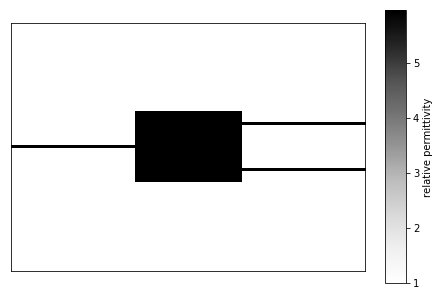

In [8]:
# define permittivity of three port system
eps_r, design_region = three_port(L, H, w, d, l, spc, dl, NPML, eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

# make a new simulation object
simulation = Simulation(omega, eps_r, dl, NPML, pol)

print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation.L0)))

# plot the permittivity distribution
simulation.plt_eps(outline=False)
plt.show()

`Simulation` objects are used for running the actual FDFD simulations and we define our optimizations over them.

## Sources and Probes

With our simulation defined, we may now define the modal profiles of our input and output ports.  

We will first add a modal source to our simulation corresponding to the port on the left.

Then, we'll create two temporary simulations that are identical to the original, add modal sources for the top and bottom ports, and use these to get numpy arrays corresponding to the top and bottom probes of the device.  While in the code we are labelling these `J_top` and `J_bot`, in the paper, these are called $\mathbf{m}_{t}$ and $\mathbf{m}_b$ respectively

In [9]:
# set the input waveguide modal source
simulation.add_mode(neff=np.sqrt(eps_m), direction_normal='x', center=[NPML[0]+int(l/2/dl), ny], width=int(H/2/dl), scale=source_amp)
simulation.setup_modes()

# make a new simulation to get the modal profile of the top output port
top = Simulation(omega, eps_r, dl, NPML, 'Hz')
top.add_mode(neff=np.sqrt(eps_m), direction_normal='x', center=[-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], width=int(H/2/dl))
top.setup_modes()
J_top = np.abs(top.src)

# make a new simulation to get the modal profile of the bottom output port
bot = Simulation(omega, eps_r, dl, NPML, 'Hz')
bot.add_mode(neff=np.sqrt(eps_m), direction_normal='x', center=[-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], width=int(H/2/dl))
bot.setup_modes()
J_bot = np.abs(bot.src)

Now we can use `J_top` and `J_bot` as probes in our objective function.  We'll no longer need the `top` and `bot` Simulations.

We can plot solve the simulation for the electric and magnetic fields and then plot the results.

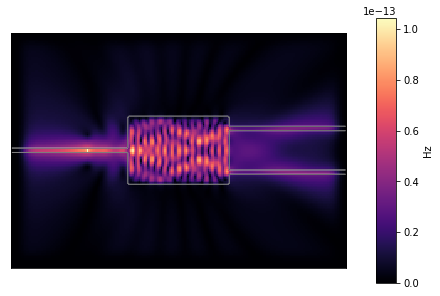

In [11]:
# set source and solve for electromagnetic fields
(Ex, Ey, Hz) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);

## Normalizing

As an optional step, we'll normalize the modal amplitudes such that $|J^T H|^2 = 1$ for perfect transmission to the port corresponding to $J$.

To do this, we'll make another temporary simulation with just a straight waveguide of the same source as our original three port.

We'll then compute $|J^T H|^2$ for the output port, and normalize `J_in` and `J_out` using this. 

computed a scale of 1.5062819149966845e-27


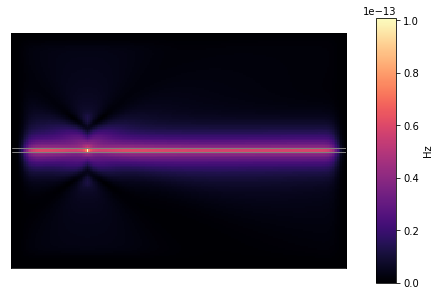

In [12]:
# compute straight line simulation
eps_r_wg, _ = two_port(L, H, w, l, spc, dl, NPML, eps_start=eps_m)
(Nx_wg, Ny_wg) = eps_r_wg.shape
nx_wg, ny_wg = int(Nx_wg/2), int(Ny_wg/2)            # halfway grid points     
simulation_wg = Simulation(omega, eps_r_wg, dl, NPML, 'Hz')
simulation_wg.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny_wg], int(Ny/3), scale=source_amp)
simulation_wg.setup_modes()

# compute normalization
sim_out = Simulation(omega, eps_r_wg, dl, NPML, 'Hz')
sim_out.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(Ny/3))
sim_out.setup_modes()
J_out = np.abs(sim_out.src)
(_, _, Hz_wg) = simulation_wg.solve_fields()
SCALE = np.sum(np.square(np.abs(Hz_wg*J_out)))
J_out = J_out
print('computed a scale of {}'.format(SCALE))

simulation_wg.plt_abs(outline=True, cbar=True);

J_top = J_top / np.sqrt(SCALE)
J_bot = J_bot / np.sqrt(SCALE)

## Changing the design region

Optionally, we can also change the design region to several different styles before optimization.  

Here we'll use `random_sym` which randomly assigns each pixel within the design region betwee 1 and the maximum permittivity.  

This is mirrored across y=0.

Making it symmetric leads to more symmetric final devices.

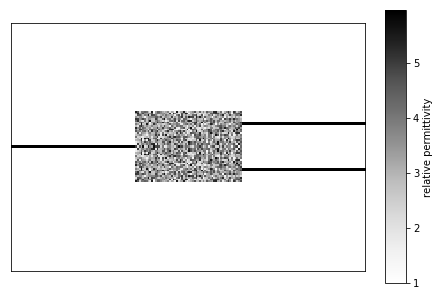

In [13]:
# changes design region. 'style' can be one of {'full', 'empty', 'halfway', 'random', 'random_sym'}.
simulation.init_design_region(design_region, eps_m, style='random_sym')
simulation.plt_eps(outline=False)
plt.show()

## Defining Objective Functions

Now is one of the most important steps: defining the objective function for optimization / inverse design.

To do this, we define a function `J` which takes in the linear fields as the first argument and the nonlinear fields as a second argument.

Until we make this more flexible, if your problem is linear, you still need the nonlinear fields argument, but you dont have to use it within the body of the function. 

We require that you define your numpy operations within J using the autograd wrapper for numpy.

This allows us to automatically compute the partial derivatives of $J$ w.r.t. $E$ and $E_{nl}$, which are used in the adjoint.  

This is super helpful when you define complicated objective functions and dont feel like computing these by hand!

Below is an example of an objective function where the top and bottom port transmissions are directly multiplied.

`angler` will try to maximize `J` w.r.t the permittivity in the design region.  Since we're multiplying the transmissions here, a highest possible value of `J = 1` will occur when each port is at 50% transmission, which is what we want.

In [14]:
# define objective function  (equal power transmission to bottom and top)
import autograd.numpy as npa
def J(h, h_nl):
    linear_top =     1*npa.sum(npa.square(npa.abs(h*J_top)))
    linear_bot =     1*npa.sum(npa.square(npa.abs(h*J_bot)))
    objfn = linear_top * linear_bot * 4
    return objfn

## Defining the Optimization

Now we are ready to define the `Optimization`, which will perform the inverse design on top of our `simulation`.  

We give the optimization our objective function, simulation object, design region, and specify the maximum permittivity to allow.

Also, we pass in some optional arguments that define the filtering and projection that are used to create smooth feature sizes.

`R` controls the minimum feature size.  
`beta` controls how strongly to bias the permittivitiy to be either air or material.

See the supplementary information of our paper (coming soon) for more details.

The `Optimization` object takes a little bit of time to initialize because we need to set up the spatial filter.

In [15]:
# make optimization object
R = 4          # filter radius of curvature (pixels)  (takes a while to set up as R > 5-10)
beta = 300     # projection strength
eta= 0.50      # projection halfway

optimization = Optimization(J=J, simulation=simulation, design_region=design_region, eps_m=eps_m, R=R, beta=beta, eta=eta)

 98% (148 of 151) |##################### | Elapsed Time: 0:00:10 ETA:   0:00:00

## Checking Adjoint Derivatives

We allow users to check that their adjoint derivatives match finite difference numerical derivatives.

This is good practice to make sure things are working correctly

In [12]:
# check the derivatives (note, full derivatives are checked, linear and nonlinear no longer separate)
(grad_avm, grad_num) = optimization.check_deriv(Npts=5, d_rho=5e-4)
print('adjoint gradient   = {}\nnumerical gradient = {}'.format(grad_avm, grad_num))

/Users/twh/autograd/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


adjoint gradient   = [-0.001085226781334129, -0.0008954340205819703, 0.00022416322159380677, 0.00029548486060976834, -0.00025799129885916935]
numerical gradient = [-0.0010844488452670976, -0.0008949635921383543, 0.00022252767979159815, 0.00029781386681358366, -0.00025940595972662184]


## Running the Optimization

Finally, we can run the optimization / inverse design.

To do this, we simply call `Optimization.run()` with some parameters.

You can try out different optimization methods and parameters, for more info, check out `angler/optimization.py`.

In [16]:
# run optimization for 400 steps
new_eps = optimization.run(method='lbfgs', Nsteps=400)

/Users/twh/autograd/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

## Plotting Results

Optimization objects have methods for visualizing the results of the run:

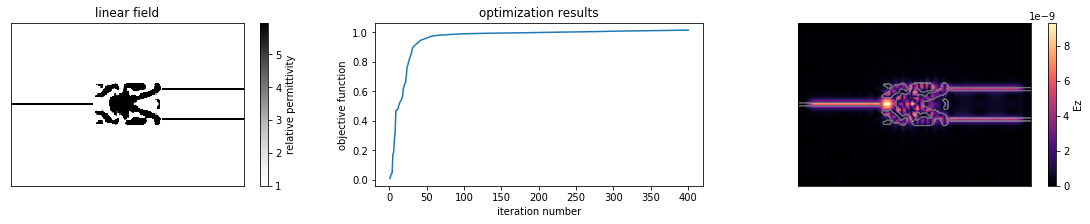

In [14]:
# plot the objective function end structure and fields
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,3))

simulation.plt_eps(ax=ax1, outline=False)
ax1.set_title('final permittivity distribution')

optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')

(_,_,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax3, vmax=None)
ax1.set_title('linear field')

plt.show()

Finally we can measure power transmission of our final `simulation`.

In [15]:
# plot transmission characteristics
W_in = simulation.W_in   # input power (W/um)

# linear powers
W_top_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], int(H/2/dl))
W_bot_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], int(H/2/dl))

print('        -> linear transmission (top)        = {:.2f} %'.format(W_top_lin / W_in * 100))
print('        -> linear transmission (bottom)     = {:.2f} %'.format(W_bot_lin / W_in * 100))

        -> linear transmission (top)        = 49.48 %
        -> linear transmission (bottom)     = 49.26 %


## Conclusion

This was a simple demo of a linear problem.  

For more functionality, please check out our other notebooks!

And if you have a question, feature request, or want to contribute, feel free to reach out on Github.